We implement the scale mixture of normals prior. In particular given a function for computing the marginal likelihood $\ell(z, s)$ we can use autograd to (1) get functions for the posterior mean and variance, and (2) get gradients for the posterior mean and variance with respect to $z, s$. 

In [16]:
import jax.numpy as jnp
import numpy as np
from jax.scipy.stats import norm
from jax.scipy.special import logsumexp
import jax
import matplotlib.pyplot as plt
import jaxopt

jax.config.update("jax_enable_x64", True)

In [2]:
# here we check that the gradient based computations work correctly for a simple test case
# y \sim N(b, 1), b \sim (0, 1)
normalize = lambda x: np.exp(x - logsumexp(x))

def log_marginal_normal(z, s, sigma=1.0):
    return norm.logpdf(z, loc=0., scale=jnp.sqrt(s**2 + sigma**2))

# compute posterior mean and variance by tweedie's formula
posterior_mean = lambda z, s: z + s**2 * jax.grad(log_marginal_normal)(z, s, 1.)
posterior_variance = lambda z, s: s**2 * (1 + s**2 * jax.grad(jax.grad(log_marginal_normal))(z, s, 1.))

z = 3.
s = 1.
# 3/2, 1 / (1 + 1)
posterior_mean(z, s), posterior_variance(z, s)

z = 1.
s = np.sqrt(0.5)
# 2/3, 1 / (1 + 2)
posterior_mean(z, s), posterior_variance(z, s)

(Array(0.66666667, dtype=float64), Array(0.33333333, dtype=float64))

In [3]:
from functools import partial

# g is a scale mixture of normals (possibly with a point mass at 0)
def log_marginal(z, s, pi, sigma_grid):
    return logsumexp(jnp.log(pi) + norm.logpdf(z, loc=0., scale=jnp.sqrt(s**2 + sigma_grid**2)))

pi = np.ones(5)/5
sigma_grid = np.arange(5) + 1
log_marginal_g = partial(log_marginal, pi=pi, sigma_grid=sigma_grid)

# this is for the gaussian error model
posterior_mean = lambda z, s: z + s**2 * jax.grad(log_marginal_g)(z, s)
posterior_variance = lambda z, s: s**2 * (1. + s**2 * jax.grad(jax.grad(log_marginal_g))(z, s))


kappa = lambda z, s: log_marginal_g(z, s) - norm.logpdf(z, 0, s)
Eeta = lambda z, s: jax.grad(kappa)(z, s)
Eeta2 = lambda z, s: Eeta(z, s)**2 + jax.grad(Eeta)(z,s)
KL = lambda z, s: z * Eeta(z, s) - Eeta2(z, s) * s**2/2 - kappa(z, s)

#KL = lambda: z, s: z * posterior_mean(z, s)/s**2 - 0.5 * posterior_variance(z, s)/s**2
# this would work substituting other exponential families
posterior_mean2 = lambda z, s: s**2 * (jax.grad(log_marginal_g)(z, s) - jax.grad(norm.logpdf)(z, 0, s))
posterior_variance2 = lambda z, s: s**4 * (jax.grad(jax.grad(log_marginal_g))(z, s) - jax.grad(jax.grad(norm.logpdf))(z, 0, s))

In [4]:
# test relationship between tweedies formula and general exponential family version
s = 4.
posterior_mean(1., s) - s**2 * Eeta(1., s)

Array(0., dtype=float64, weak_type=True)

In [5]:
# test relationship between tweedies formula and general exponential family version
posterior_variance2 = lambda z, s: s**4 * Eeta2(z, s) - (s**2 * Eeta(z, s))**2
z, s = 1., 4.
posterior_variance(z, s) - posterior_variance2(z, s)

Array(0., dtype=float64, weak_type=True)

In [6]:
# this is for the gaussian error model
def make_functions(log_marginal_g):
    # tweedie type formula for posterior mean and variance
    posterior_mean = lambda z, s: z + s**2 * jax.grad(log_marginal_g)(z, s)
    posterior_variance = lambda z, s: s**2 * (1. + s**2 * jax.grad(jax.grad(log_marginal_g))(z, s))

    # natural parameter
    kappa = lambda z, s: log_marginal_g(z, s) - norm.logpdf(z, 0, s)
    Eeta = lambda z, s: jax.grad(kappa)(z, s)
    Eeta2 = lambda z, s: Eeta(z, s)**2 + jax.grad(Eeta)(z,s)
    KL = lambda z, s: z * Eeta(z, s) - 0.5 * Eeta2(z, s) * s**2 - kappa(z, s)
    
    def Eqlogp(z, s, X, y, tau):
        mu = jax.vmap(posterior_mean)(z, s)
        V = jax.vmap(posterior_variance)(z, s)
        yhat = X @ mu
        d = jnp.diag(X.T @ X)
        return - 0.5 * tau * (jnp.sum((y - yhat)**2) + jnp.sum(d * V))
    
    def elbo(z, s, X, y, tau):
        return Eqlogp(z, s, X, y, tau) - jnp.sum(jax.vmap(KL)(z, s))

    def posterior(nu):
        z = nu['z']
        s = jnp.log(1 + jnp.exp(nu['log1exps']))
        mu = jax.vmap(posterior_mean)(z, s)
        var = jax.vmap(posterior_variance)(z, s)
        return mu, var

    def objective(nu, X, y, tau):
        z = nu['z']
        s = jnp.log(1 + jnp.exp(nu['log1exps']))
        return -elbo(z, s, X, y, tau)
    
    def fit_lbfgs(y, X, tau, maxiter=100):
        p = X.shape[1]
        solver = jaxopt.ScipyMinimize(fun=objective, maxiter=maxiter)
        nu = dict(z=np.zeros(p), log1exps=np.ones(p)) # initialize variational parameters
        res = solver.run(nu, X=X, y=y, tau=tau) # optimize  
        mu, var = posterior(res.params)
        return dict(res=res, mu=mu, var=var)
        
    return fit_lbfgs, objective, posterior, KL

## Gaussian error, gaussian prior

In this special case, we can implement the CAVI updates very easily in closed form.
We see good agreement between the CAVI results and gradient descent on the compound objective.

### Fixed $g$

In [10]:
# mean field updates
# simulate
def simulate_gaussian(n, p, tau=1, tau0=1., seed=1):
    np.random.seed(seed)
    X = np.random.normal(size=(n, p))
    b = np.random.normal(size=p) / np.sqrt(tau0)
    y = X @ b + np.random.normal(size=n)/np.sqrt(tau)
    return dict(y=y, X=X, b=b, tau=tau, tau0=tau0, seed=seed)

def kl_univariate_gaussian(muq, varq, varg):
    return 0.5 * np.sum((varq + muq**2)/varg + np.log(varg/varq)  - 1)

def elbo_cavi(mu, var, y, X, tau, tau0):
    ybar = X @ mu
    d = np.diag(X.T @ X)
    #kl = 0.5 * np.sum((var + mu)**2 * tau0 + np.log(tau0 * var)  - 1)
    kl = kl_univariate_gaussian(mu, var, 1/tau0)
    Eloglik =  -0.5 * tau * np.sum((y-ybar)**2) - 0.5 * tau * np.sum(d * var)
    return Eloglik - kl

def gaussian_mr_cavi(y, X, tau, tau0, maxiter=100):
    n, p = X.shape
    mu = np.zeros(X.shape[1])
    var = np.ones(X.shape[1])
    d = np.diag(X.T @ X)
    r = y - X @ mu
    elbos = [elbo_cavi(mu, var, y, X, tau, tau0)]
    for i in range(maxiter):
        for j in range(p):
            r = r + X[:, j] * mu[j]
            shrink = tau * d[j] /(tau * d[j] + tau0) 
            bhat = np.sum(r * X[:, j]) / d[j]
            mu[j] = shrink * bhat
            var[j] = 1/(tau * d[j] + tau0)
            r = r - X[:,j] * mu[j]
        elbos.append(elbo_cavi(mu, var, y, X, tau, tau0))
    return dict(mu=mu, var=var, elbo=np.array(elbos), tau=tau, tau0=tau0)

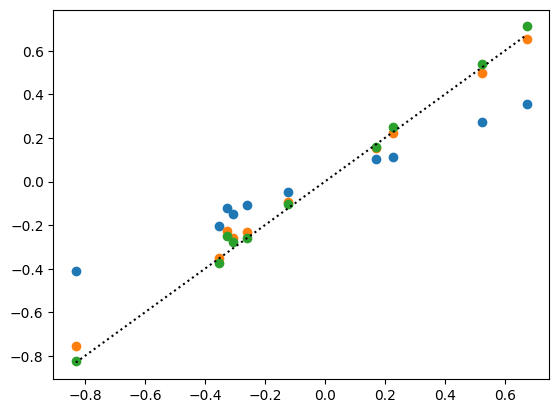

In [14]:
# the larger the prior precision, the more aggressive shrinkage.
sim = simulate_gaussian(1000, 10, tau=1., tau0=1.)
get_range = lambda x: [x.min(), x.max()]

y, X, b = sim['y'], sim['X'], sim['b']
cavi_fit1 = gaussian_mr_cavi(y, X, 1., 1000.)
cavi_fit2 = gaussian_mr_cavi(y, X, 1., 100.)
cavi_fit3 = gaussian_mr_cavi(y, X, 1., 10.)
plt.scatter(b, cavi_fit1['mu'])
plt.scatter(b, cavi_fit2['mu'])
plt.scatter(b, cavi_fit3['mu'])
plt.plot(get_range(b), get_range(b), c='k', linestyle='dotted')

(-0.8305534427050055, 0.6736230984302903)

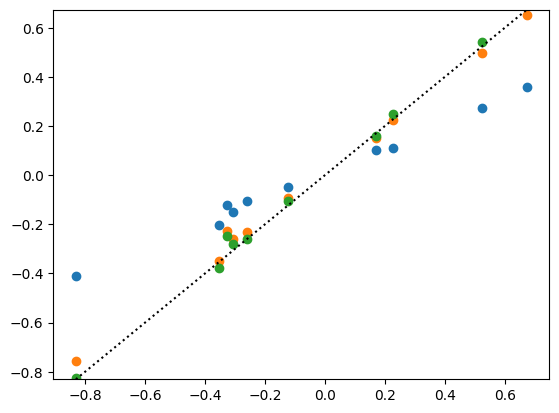

In [17]:
def log_marginal_normal(z, s, tau0):
    return norm.logpdf(z, loc=0., scale=jnp.sqrt(s**2 + 1/tau0))

maxiter = 1000
fit_lbfgs, objective, posterior, KL = make_functions(partial(log_marginal_normal, tau0=1000.))
compound_fit1 = fit_lbfgs(y, X, 1., maxiter)

fit_lbfgs, objective, posterior, KL = make_functions(partial(log_marginal_normal, tau0=100.))
compound_fit2 = fit_lbfgs(y, X, 1., maxiter)

fit_lbfgs, objective, posterior, KL = make_functions(partial(log_marginal_normal, tau0=10.))
compound_fit3 = fit_lbfgs(y, X, 1., maxiter)

plt.scatter(b, compound_fit1['mu'])
plt.scatter(b, compound_fit2['mu'])
plt.scatter(b, compound_fit3['mu'])
plt.plot(get_range(b), get_range(b), c='k', linestyle='dotted')
plt.ylim(get_range(b))

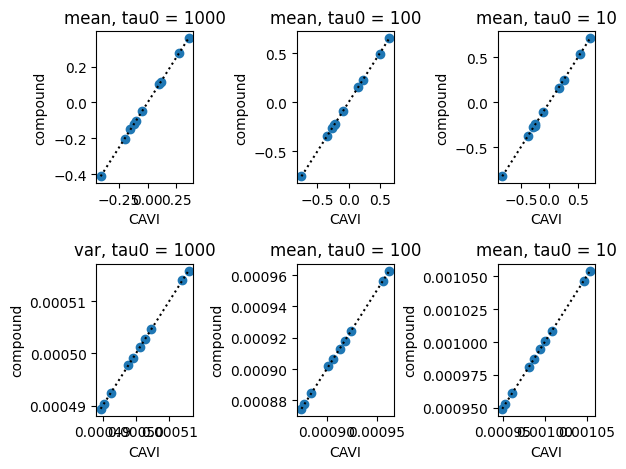

In [26]:
fig, ax = plt.subplots(2, 3)

plt.sca(ax[0,0])
plt.scatter(cavi_fit1['mu'], compound_fit1['mu'])
plt.plot(get_range(cavi_fit1['mu']), get_range(cavi_fit1['mu']), color='k', linestyle='dotted')
plt.title('mean, tau0 = 1000')
plt.xlabel('CAVI')
plt.ylabel('compound')

plt.sca(ax[0,1])
plt.scatter(cavi_fit2['mu'], compound_fit2['mu'])
plt.plot(get_range(cavi_fit2['mu']), get_range(cavi_fit2['mu']), color='k', linestyle='dotted')
plt.title('mean, tau0 = 100')
plt.xlabel('CAVI')
plt.ylabel('compound')

plt.sca(ax[0,2])
plt.scatter(cavi_fit3['mu'], compound_fit3['mu'])
plt.plot(get_range(cavi_fit3['mu']), get_range(cavi_fit3['mu']), color='k', linestyle='dotted')
plt.title('mean, tau0 = 10')
plt.xlabel('CAVI')
plt.ylabel('compound')


plt.sca(ax[1,0])
plt.scatter(cavi_fit1['var'], compound_fit1['var'])
plt.plot(get_range(cavi_fit1['var']), get_range(cavi_fit1['var']), color='k', linestyle='dotted')
plt.title('var, tau0 = 1000')
plt.xlabel('CAVI')
plt.ylabel('compound')

plt.sca(ax[1,1])
plt.scatter(cavi_fit2['var'], compound_fit2['var'])
plt.plot(get_range(cavi_fit2['var']), get_range(cavi_fit2['var']), color='k', linestyle='dotted')
plt.title('mean, tau0 = 100')
plt.xlabel('CAVI')
plt.ylabel('compound')

plt.sca(ax[1,2])
plt.scatter(cavi_fit3['var'], compound_fit3['var'])
plt.plot(get_range(cavi_fit3['var']), get_range(cavi_fit3['var']), color='k', linestyle='dotted')
plt.title('mean, tau0 = 10')
plt.xlabel('CAVI')
plt.ylabel('compound')

plt.tight_layout()

In [35]:
print(f"CAVI solution ELBO = {cavi_fit1['elbo'][-1]:.2f}, Combound solution ELBO = {-compound_fit1['res'].state.fun_val:.2f}")

CAVI solution ELBO = -982.67, Combound solution ELBO = -982.67


### Estimate prior variance

Now we will try to estimate the prior variance. There is only one parameter controlling the prior family, namely, the prior variance. 
A simple strategy is to look across a fixed grid of values. Then we will try to optimize the ELBO w.r.t the prior variance through gradient based optimization.

In [36]:
# this is for the gaussian error model
def make_functions2(log_marginal_g, transforms):
    # tweedie type formula for posterior mean and variance
    posterior_mean = lambda z, s, params: z + s**2 * jax.grad(log_marginal_g)(z, s, **params)
    posterior_variance = lambda z, s, params: s**2 * (1. + s**2 * jax.grad(jax.grad(log_marginal_g))(z, s, **params))

    # natural parameter
    kappa = lambda z, s, params: log_marginal_g(z, s, **params) - norm.logpdf(z, 0, s)
    Eeta = lambda z, s, params: jax.grad(kappa)(z, s, params)
    Eeta2 = lambda z, s, params: Eeta(z, s, params)**2 + jax.grad(Eeta)(z,s, params)
    KL = lambda z, s, params: z * Eeta(z, s, params) - 0.5 * Eeta2(z, s, params) * s**2 - kappa(z, s, params)
    
    def Eqlogp(z, s, params, X, y, tau):
        mu = jax.vmap(posterior_mean, (0, 0, None))(z, s, params)
        V = jax.vmap(posterior_variance, (0, 0, None))(z, s, params)
        yhat = X @ mu
        d = jnp.diag(X.T @ X)
        return - 0.5 * tau * (jnp.sum((y - yhat)**2) + jnp.sum(d * V))
    
    def elbo(z, s, params, X, y, tau):
        return Eqlogp(z, s, params, X, y, tau) - jnp.sum(jax.vmap(KL, (0, 0, None))(z, s, params))

    def posterior(nu):
        z = nu['z']
        s = jnp.log(1 + jnp.exp(nu['s']))
        params = {k: transforms[k](v) for k, v in nu['params'].items()}
        mu = jax.vmap(posterior_mean, (0, 0, None))(z, s, params)
        var = jax.vmap(posterior_variance, (0, 0, None))(z, s, params)
        return mu, var

    # we can take gradients with respect to nu, which includes variational parameters and the parameters of the prior
    def objective(nu, X, y, tau):
        z = nu['z']
        s = jnp.log(1 + jnp.exp(nu['s']))
        params = {k: transforms[k](v) for k, v in nu['params'].items()}
        return -elbo(z, s, params, X, y, tau)
    
    def fit_lbfgs(y, X, tau, nu_init, maxiter=100):
        p = X.shape[1]
        solver = jaxopt.ScipyMinimize(fun=objective, maxiter=maxiter)
        nu = dict(z=np.zeros(p), log1exps=np.ones(p)) # initialize variational parameters
        res = solver.run(nu_init, X=X, y=y, tau=tau) # optimize  
        mu, var = posterior(res.params)
        return dict(res=res, mu=mu, var=var)
        
    return fit_lbfgs, objective, posterior, KL

In [75]:
# more variables here so that there are enough examples to learn the prior variance from.
n, p = 1000, 100
sim = simulate_gaussian(n, p, tau=1., tau0=10., seed=2)
get_range = lambda x: [x.min(), x.max()]
y, X, b = sim['y'], sim['X'], sim['b']

transforms = dict(
    tau0 = lambda x: jnp.log(1 + jnp.exp(x))
)
nu_init = dict(
    z = np.zeros(p),
    s = np.ones(p),
    params = dict(
        tau0 = 10.
    )
)
def log_marginal_normal(z, s, tau0=1.0):
    return norm.logpdf(z, loc=0., scale=jnp.sqrt(s**2 + 1/tau0))

In [76]:
tau0s = 10**np.linspace(0, 1.5, 50)
cavi_fits = [gaussian_mr_cavi(y, X, 1., tau0) for tau0 in tau0s]
elbos = np.array([fit['elbo'][-1] for fit in cavi_fits])

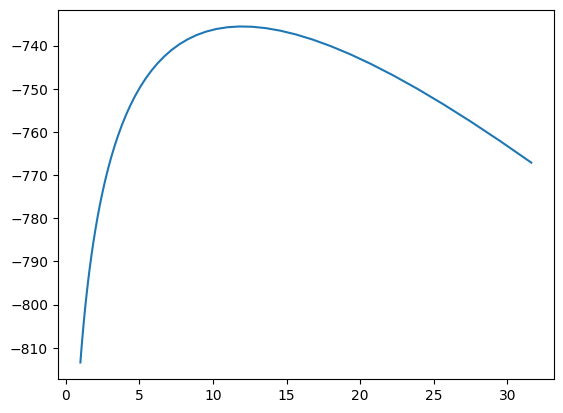

In [77]:
plt.plot(tau0s, elbos)

In [ ]:
def fit_fixed_tau0(tau0):
    maxiter = 10000
    fit_lbfgs, objective, posterior, KL = make_functions(partial(log_marginal_normal, tau0=tau0))
    return fit_lbfgs(y, X, 1., maxiter)

compound_fits = [fit_fixed_tau0(tau0) for tau0 in tau0s]
compound_elbos = np.array([fit['res'].state.fun_val for fit in compound_fits])
plt.plot(tau0s, compound_elbos)

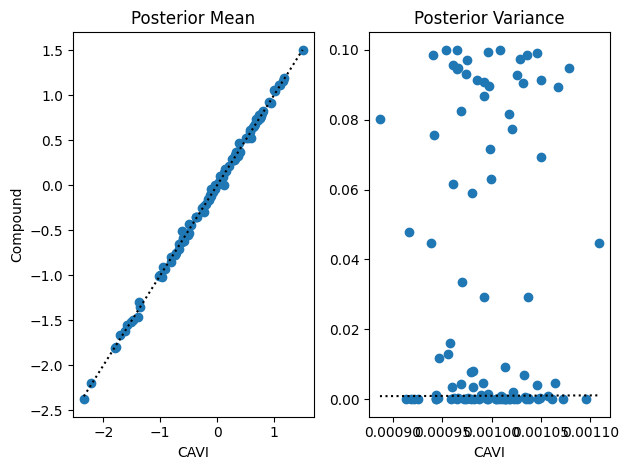

CAVI solution ELBO = -1019.20, Combound solution ELBO = -2636.74


In [89]:
sim = simulate_gaussian(1000, 100, tau=1., tau0=1., seed=1)
get_range = lambda x: [x.min(), x.max()]

tau0 = 10.

y, X, b = sim['y'], sim['X'], sim['b']
cavi_fit = gaussian_mr_cavi(y, X, 1., tau0)

maxiter = 10000
fit_lbfgs, objective, posterior, KL = make_functions(partial(log_marginal_normal, tau0=tau0))
compound_fit = fit_lbfgs(y, X, 1., maxiter)

def plot_mu(cavi_fit, compound_fit):
    fig, ax = plt.subplots(1, 2)
    plt.sca(ax[0])
    plt.scatter(cavi_fit['mu'], compound_fit['mu'])
    plt.plot(get_range(cavi_fit['mu']), get_range(cavi_fit['mu']), color='k', linestyle='dotted')
    plt.title('Posterior Mean')
    plt.ylabel('Compound')
    plt.xlabel('CAVI')
    
    plt.sca(ax[1])
    plt.scatter(cavi_fit['var'], compound_fit['var'])
    plt.plot(get_range(cavi_fit['var']), get_range(cavi_fit['var']), color='k', linestyle='dotted')
    plt.title('Posterior Variance')
    plt.xlabel('CAVI')

    plt.tight_layout()
    plt.show()

plot_mu(cavi_fit, compound_fit)
print(f"CAVI solution ELBO = {cavi_fit['elbo'][-1]:.2f}, Combound solution ELBO = {-compound_fit['res'].state.fun_val:.2f}")

In [314]:
tau0 = 10.
cavi_fit = gaussian_mr_cavi(y, X, 1., tau0)
compound_fit = fit_fixed_tau0(tau0)

In [318]:
cavi_fit['elbo'][-1], compound_fit['res'].state.fun_val

(np.float64(-736.332976336279),
 Array(3432.76481919, dtype=float64, weak_type=True))

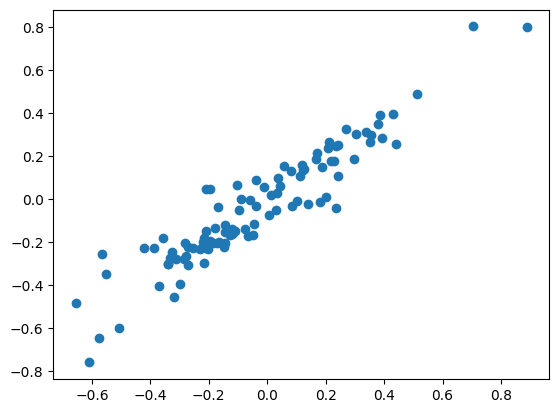

In [323]:
plt.scatter(cavi_fit['mu'], compound_fit['mu'])

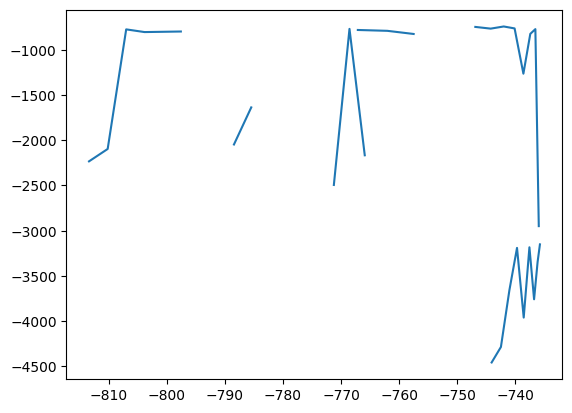

In [312]:
elbos2 = [-fit['res'].state.fun_val for fit in fits]
plt.plot(elbos, elbos2)

In [313]:
elbos2

[Array(-2233.08828511, dtype=float64, weak_type=True),
 Array(-2096.18983947, dtype=float64, weak_type=True),
 Array(-774.02871917, dtype=float64, weak_type=True),
 Array(-803.84306293, dtype=float64, weak_type=True),
 Array(-800.70384499, dtype=float64, weak_type=True),
 Array(-797.59266662, dtype=float64, weak_type=True),
 Array(nan, dtype=float64, weak_type=True),
 Array(nan, dtype=float64, weak_type=True),
 Array(-2046.6561363, dtype=float64, weak_type=True),
 Array(-1636.65300844, dtype=float64, weak_type=True),
 Array(nan, dtype=float64, weak_type=True),
 Array(-1559.64058631, dtype=float64, weak_type=True),
 Array(nan, dtype=float64, weak_type=True),
 Array(nan, dtype=float64, weak_type=True),
 Array(-2494.04162933, dtype=float64, weak_type=True),
 Array(-768.55212925, dtype=float64, weak_type=True),
 Array(-2166.01574364, dtype=float64, weak_type=True),
 Array(nan, dtype=float64, weak_type=True),
 Array(nan, dtype=float64, weak_type=True),
 Array(nan, dtype=float64, weak_type=T

In [304]:
maxiter = 100
#fit = fit_lbfgs(y, X, 1., maxiter)
#fit['res'].state.fun_val

transforms = dict(
    tau0 = lambda x: jnp.log(1 + jnp.exp(x))
)
nu_init = dict(
    z = np.zeros(p),
    s = np.ones(p),
    params = dict(
        tau0 = 10.
    )
)

fit_lbfgs, objective, posterior, KL = make_functions2(log_marginal_normal, transforms)
res = fit_lbfgs(y, X, 1., nu_init, maxiter=10)

In [305]:
res['res'].params['params']['tau0']

Array(9.96947586, dtype=float64)

In [306]:
res['res'].state.fun_val

Array(5607.1786817, dtype=float64, weak_type=True)

## Different error models

In [156]:
# this is for the gaussian error model
def log_likelihood_normal(b, X, y, tau=1.0):
    yhat = X@b
    return 0.5 * jnp.log(tau/(2 * jnp.pi)) - 0.5 * tau * jnp.sum((y - yhat)**2)

def make_functions3(log_likelihood, log_marginal_g, transforms):
    # tweedie type formula for posterior mean and variance
    posterior_mean = lambda z, s, params, fixed_params: z + s**2 * jax.grad(log_marginal_g)(z, s, **params, **fixed_params)
    posterior_variance = lambda z, s, params, fixed_params: s**2 * (1. + s**2 * jax.grad(jax.grad(log_marginal_g))(z, s, **params, **fixed_params))

    # natural parameter
    kappa = lambda z, s, params, fixed_params: log_marginal_g(z, s, **params, **fixed_params) - norm.logpdf(z, 0, s)
    Eeta = lambda z, s, params, fixed_params: jax.grad(kappa)(z, s, params, fixed_params)
    Eeta2 = lambda z, s, params, fixed_params: Eeta(z, s, params, fixed_params)**2 + jax.grad(Eeta)(z,s, params, fixed_params)
    KL = lambda z, s, params, fixed_params: z * Eeta(z, s, params, fixed_params) - 0.5 * Eeta2(z, s, params, fixed_params) * s**2 - kappa(z, s, params, fixed_params)
    
    def Eqlogp(z, s, lparams, lparams_fixed, gparams, gparams_fixed, X, y):
        mu = jax.vmap(posterior_mean, (0, 0, None, None))(z, s, gparams, gparams_fixed)
        V = jax.vmap(posterior_variance, (0, 0, None, None))(z, s, gparams, gparams_fixed)
        # possible speed up: https://github.com/jax-ml/jax/issues/3801#issuecomment-2155354413
        D = jnp.diag(jax.hessian(log_likelihood)(mu, X, y, **lparams, **lparams_fixed))
        return log_likelihood(mu, X, y, **lparams, **lparams_fixed) + jnp.sum(D * V)
    
    def elbo(z, s, lparams, lparams_fixed, gparams, gparams_fixed, X, y):
        return Eqlogp(z, s, lparams, lparams_fixed, gparams, gparams_fixed, X, y) - jnp.sum(jax.vmap(KL, (0, 0, None, None))(z, s, gparams, gparams_fixed))

    def posterior(params, params_fixed):
        z = params['z']
        s = jnp.log(1 + jnp.exp(params['s']))
        gparams = {k: transforms[k](v) for k, v in params['gparams'].items()}
        gparams_fixed = params_fixed['gparams']
        mu = jax.vmap(posterior_mean, (0, 0, None, None))(z, s, gparams, gparams_fixed)
        var = jax.vmap(posterior_variance, (0, 0, None, None))(z, s, gparams, gparams_fixed)
        return mu, var

    # we can take gradients with respect to nu, which includes variational parameters and the parameters of the prior
    def objective(params, params_fixed, X, y):
        z = params['z']
        s = jnp.log(1 + jnp.exp(params['s']))
        lparams = {k: transforms[k](v) for k, v in params['lparams'].items()}
        lparams_fixed = params_fixed['lparams']
        gparams = {k: transforms[k](v) for k, v in params['gparams'].items()}
        gparams_fixed = params_fixed['gparams']
        return -elbo(z, s, lparams, lparams_fixed, gparams, gparams_fixed, X, y)
    
    def fit(y, X, params_init, params_fixed, maxiter=100):
        p = X.shape[1]
        solver = jaxopt.ScipyMinimize(fun=objective, maxiter=maxiter)
        res = solver.run(params_init, X=X, y=y, params_fixed=params_fixed) # optimize  
        mu, var = posterior(res.params, params_fixed)
        return dict(res=res, mu=mu, var=var)
        
    return fit, objective, posterior, KL

In [209]:
transforms = dict(
    tau0 = lambda x: jnp.log(1 + jnp.exp(x))
)

params_init = dict(
    z = np.zeros(p),
    s = np.ones(p),
    gparams = dict(),
    lparams = dict(),
)

params_fixed = dict(
    lparams = dict(tau = 0.01), # residual error precision
    gparams = dict(tau0 = 10.) # prior effect precision
)

fit_fun, objective, posterior, KL = make_functions3(log_likelihood_normal, log_marginal_normal, transforms)
sim = simulate_gaussian(1000, 100, tau=1., tau0=1., seed=1)
y, X, b = sim['y'], sim['X'], sim['b']
fit = fit_fun(y, X, params_init, params_fixed, maxiter=100)
cavi_fit = gaussian_mr_cavi(y, X, tau=.01, tau0=10.0)

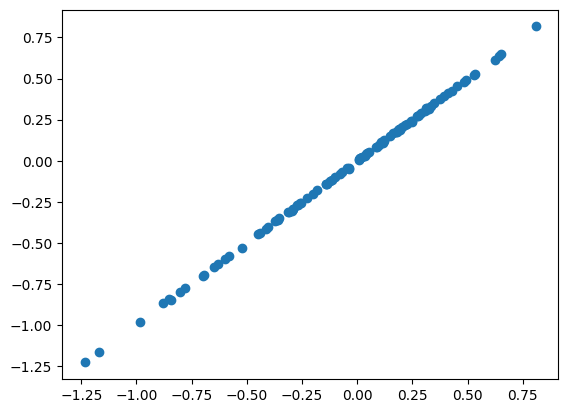

In [210]:
plt.scatter(cavi_fit['mu'], fit['mu'])

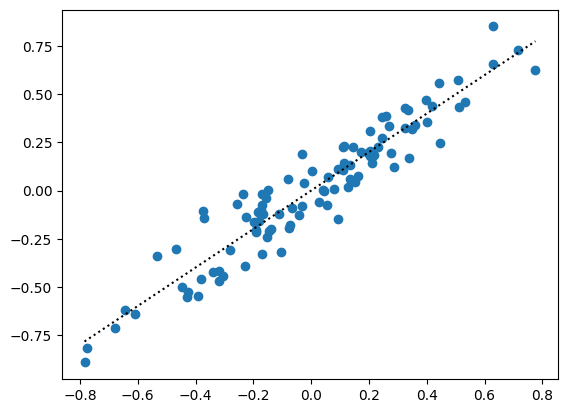

In [211]:
# mean field updates
# simulate
def log_likelihood_logistic(b, X, y):
    eta = X@b
    return jnp.sum(y * eta - jnp.log(1 + jnp.exp(eta)))
    
def simulate_logistic(n, p, tau0=1., seed=1):
    np.random.seed(seed)
    X = np.random.normal(size=(n, p))
    b = np.random.normal(size=p) / np.sqrt(tau0)
    logit = X @ b
    p = 1 / (1 + np.exp(-logit))
    y = np.random.binomial(1, p)
    return dict(y=y, X=X, b=b, tau0=tau0, seed=seed)
    
    transforms = dict(
    tau0 = lambda x: jnp.log(1 + jnp.exp(x))
)

params_init = dict(
    z = np.zeros(p),
    s = np.ones(p),
    gparams = dict(),
    lparams = dict(),
)

params_fixed = dict(
    lparams = dict(), # residual error precision
    gparams = dict(tau0 = 10.) # prior effect precision
)

fit_fun, objective, posterior, KL = make_functions3(log_likelihood_logistic, log_marginal_normal, transforms)

sim = simulate_logistic(1000, 100, tau0=10., seed=11)
y, X, b = sim['y'], sim['X'], sim['b']
fit_logistic = fit_fun(y, X, params_init, params_fixed, maxiter=100)
plt.scatter(b, compound_fit_logistic['mu'])
plt.plot(get_range(b), get_range(b), color='k', linestyle='dotted')

## Scale mixture of normals

In [182]:
# g is a scale mixture of normals (possibly with a point mass at 0)
def log_marginal(z, s, pi, sigma_grid):
    return logsumexp(jnp.log(pi) + norm.logpdf(z, loc=0., scale=jnp.sqrt(s**2 + sigma_grid**2)))

def simulate(n, p, tau=1, pi=np.ones(2)*0.5, sigma_grid=np.array([0., 1.]),seed=1):
    np.random.seed(seed)
    X = np.random.normal(size=(n, p))
    b = np.random.normal(size=p) * np.random.choice(sigma_grid, p, replace=True, p=pi)
    y = X @ b + np.random.normal(size=n)/np.sqrt(tau)
    return dict(y=y, X=X, b=b, tau=tau, pi=pi, sigma_grid=sigma_grid, seed=seed)


In [183]:
?np.random.sample

Signature:   np.random.sample(*args, **kwargs)
Type:        cython_function_or_method
String form: <cyfunction sample at 0x11b03f510>
Docstring:  
This is an alias of `random_sample`. See `random_sample`  for the complete
documentation.

In [190]:
sim = simulate(1000, 1000)

### Fixed $g$

(-3.2863255648439678, 3.123929954789383)

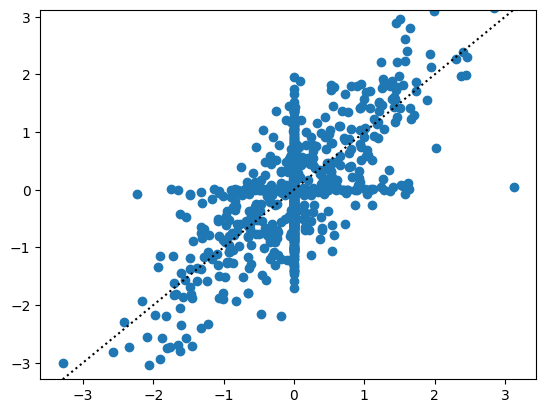

In [195]:
X, y, b = sim['X'], sim['y'], sim['b']

pi = np.ones(2) / 2
sigma_grid = np.arange(2)
log_marginal_g = partial(log_marginal, pi=pi, sigma_grid=sigma_grid)


maxiter = 1000
fit_lbfgs, objective, posterior, KL = make_functions(log_marginal_g)
compound_fit = fit_lbfgs(y, X, 1., maxiter)

plt.scatter(b, compound_fit['mu'])
plt.plot(get_range(b), get_range(b), c='k', linestyle='dotted')
plt.ylim(get_range(b))

### Estimate $g$: scale mixture of normals

Can we estimate $\pi$?

First we rewrite the objective function generator so that it can take extra arguments.

In [244]:
n, p = X.shape
pi = np.ones(2) / 2
sigma_grid = np.arange(2)

# still needs kwarg pi
log_marginal_g = partial(log_marginal, sigma_grid=sigma_grid)


normalize = lambda x: jnp.exp(x - logsumexp(x))

transforms = dict(
    pi = lambda x: normalize(jnp.concat([jnp.zeros(1), x]))
)
nu_init = dict(
    z = np.zeros(p),
    s = np.ones(p),
    params = dict(
        pi = np.ones(1)
    )
)

fit_lbfgs, objective, posterior, KL = make_functions2(log_marginal_g, transforms)
res = fit_lbfgs(y, X, 1., nu_init, maxiter=10)

In [245]:
res['res'].state.fun_val

Array(257171.97473841, dtype=float64, weak_type=True)

In [246]:
res['res'].params['params']['pi'], transforms['pi'](res['res'].params['params']['pi'])

(Array([-57.26714742], dtype=float64),
 Array([1.00000000e+00, 1.34646131e-25], dtype=float64))

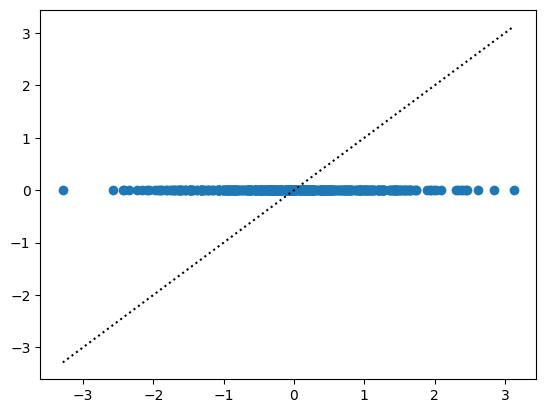

In [247]:
mu, var = posterior(res['res'].params)
plt.scatter(b, mu)
plt.plot(get_range(b), get_range(b), color='k', linestyle='dotted')

## Logistic regression

The other change we want to make is to 

In [160]:
z, s = compound_fit3['res'].params['z'], np.log(1 + np.exp(compound_fit3['res'].params['log1exps']))
jax.vmap(KL)(z, s).sum()

Array(27.74933929, dtype=float64)

In [161]:
mu, var = posterior(compound_fit3['res'].params)
kl_univariate_gaussian(mu, var, 0.1)

Array(27.74933929, dtype=float64)

In [163]:
mu, var = compound_fit3['mu'], compound_fit3['var']
compound_fit3['res'].state.fun_val, -elbo_cavi(mu, var, y, X, 1., 10.), -elbo_cavi(cavi_fit3['mu'], cavi_fit3['var'], y, X, 1., 10.)

(Array(523.85889506, dtype=float64, weak_type=True),
 Array(523.85889506, dtype=float64),
 np.float64(523.8588950591209))

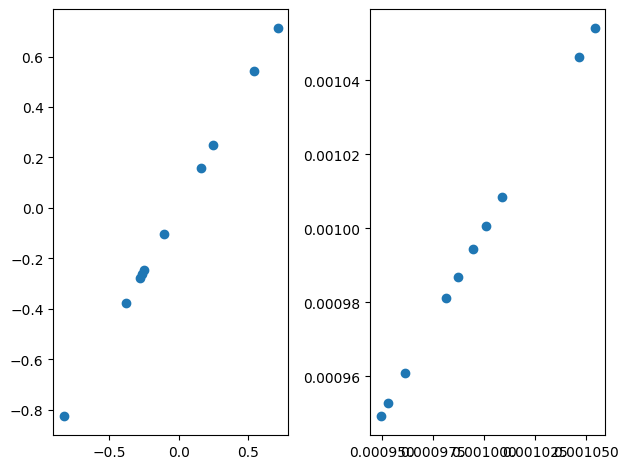

In [164]:
fit, ax = plt.subplots(1, 2)
plt.sca(ax[0])
plt.scatter(cavi_fit3['mu'], compound_fit3['mu'])

plt.sca(ax[1])
plt.scatter(cavi_fit3['var'], compound_fit3['var'])

plt.tight_layout()

Array([-0.13567134,  0.26544161, -0.40584675, -0.85080322, -0.30657902,
        0.12930233,  0.7454886 , -0.24539989, -0.26072837,  0.57516103],      dtype=float64)

In [19]:
np.arange(9).reshape((3, 3))[:, -1]

array([2, 5, 8])

In [130]:
objective(nu, X, y), objective(res.params, X, y)

(Array(11018.78375662, dtype=float64), Array(-1.32008246e+18, dtype=float64))

In [131]:
z = res.params['z']
s = np.exp(res.params['logs'])
jnp.sum(jax.vmap(KL)(z, s))

Array(-5.08062333e+17, dtype=float64)

In [132]:
Eqlogp(z, s, X, y)

Array(-10270147.73771521, dtype=float64)

In [133]:
-elbo(z, s, X, y)

Array(-5.08062333e+17, dtype=float64)

In [134]:
objective(res.params, X, y)

Array(-1.32008246e+18, dtype=float64)

In [135]:
res.params

{'logs': Array([-32.65431832, -33.99137097, -32.41550529, -34.4223221 ,
        -33.20838334, -33.72765494, -32.46054413, -33.43432489,
        -35.88141027, -36.70303223], dtype=float64),
 'z': Array([-16.64609876,  72.32127877, -65.75067104, -86.75400856,
        -36.24869933,   2.84979608,  -5.43784215,  38.26865343,
        -17.63772068,   3.67401776], dtype=float64)}

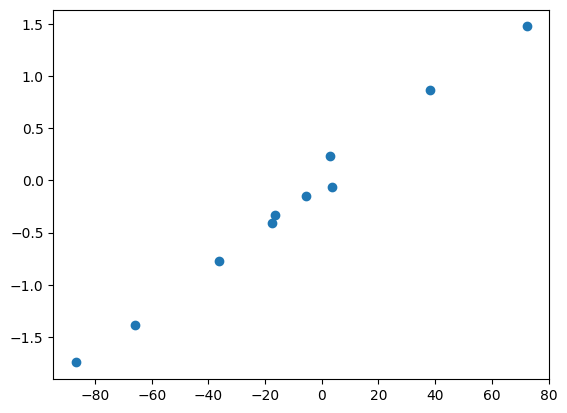

In [67]:
objective(res.params, X=X, y=y)

Array(-1.17427129e+108, dtype=float64)

In [6]:
posterior_variance2(1., 2.)

Array(2.23706796, dtype=float64, weak_type=True)

In [7]:
# the posterior variance computations doesjnp.sum(pi * sigma_grid**2), np.sum(post_assignment * post_var), posterior_variance(z, s)

In [8]:
# posterior means agree
z = 0.
s = 10.

# posterior distribution for normal means model when g = scale mixture of normals.
post_mean = z * sigma_grid**2 / (s**2 + sigma_grid**2)
post_var = s**2 * sigma_grid**2 / (s**2 + sigma_grid**2)
log_normalizing_const = norm.logpdf(z, 0, scale = np.sqrt(s**2 + sigma_grid**2))
post_assignment = normalize(np.log(pi) + log_normalizing_const) # sums to one
eQ = - 0.5 * 1/s**2 * ((post_mean - z)**2 + post_var)
kl_q_g = jnp.sum(post_assignment * eQ) - logsumexp(jnp.log(pi) + log_normalizing_const)

# posterior mean computation is working
# posterior variance computation does not seem to be working
np.sum(post_assignment * post_mean) - posterior_mean2(z, s), np.sum(post_assignment * post_var) - posterior_variance2(z, s)

(Array(0., dtype=float64), Array(7.10542736e-15, dtype=float64))

In [ ]:
#posterior_mean2 = jax.vmap(lambda nu: posterior_mean(nu[0], jnp.exp(nu[1])))
#posterior_variance2 = jax.vmap(lambda nu: posterior_variance(nu[0], jnp.exp(nu[1])))
posterior_assignment = lambda: normalize(np.log(pi) + norm.logpdf(nu[0], 0, scale = np.sqrt(np.exp(nu[1]) + sigma_grid**2)))

def loglik(nu, y, X):
    b = nu[:, 0]
    v = jnp.exp(nu[:, 1])
    d = jnp.diag(X.T @ X)
    return -0.5 * jnp.sum(y - X@b) - 0.5 * jnp.sum(d * v)

def kl(nu):
    post_mean = posterior_mean(nu)
    post_var = posterior_variance(nu)
    post_assingment = posterior_assignment(nu)
    


In [42]:
nu = np.array([z, np.log(s)])
posterior_mean2(nu), posterior_variance2(nu), 

(Array(3.5166755, dtype=float32), Array(1.0133736, dtype=float32))

In [88]:
jax.grad(posterior_mean2)(nu)

Array([ 0.2099328, -2.70177  ], dtype=float32)

In [89]:
jax.grad(posterior_variance2)(nu)

Array([0.71372473, 4.8463917 ], dtype=float32)

In [90]:
posterior_mean3 = jax.vmap(posterior_mean2)
posterior_variance3 = jax.vmap(posterior_variance2)

In [91]:
posterior_variance2(nu)

Array(20.993286, dtype=float32)

In [95]:
# gradient based computation
nu = np.array([z, np.log(s)])
posterior_mean2(nu), posterior_variance2(nu)

(Array(1.8652706, dtype=float32), Array(20.993286, dtype=float32))

In [92]:
# analytic computation
normalize = lambda x: np.exp(x - logsumexp(x))
tau_grid = 1/sigma_grid**2
gamma = 1/np.exp(nu[1])
b = nu[0]
posterior_variance_grid = 1/(gamma + tau_grid)
posterior_pi = normalize(jnp.log(pi) + norm.logpdf(b, 0, np.sqrt(1/gamma + 1/tau_grid)))
np.sum(posterior_variance_grid * posterior_pi)

/var/folders/0q/xlv6fxx51c17jf27j1ws0wx40000gn/T/ipykernel_97861/2498233326.py:3: RuntimeWarning: divide by zero encountered in divide
  tau_grid = 1/sigma_grid**2


np.float64(7.633511455047038)

In [94]:
posterior_variance_grid

array([0.        , 0.90909091, 2.85714286, 4.73684211, 6.15384615,
       7.14285714, 7.82608696, 8.30508475, 8.64864865, 8.9010989 ])

In [69]:
X = np.random.normal(size=(100, 10))
Nu = np.random.normal(size=(10, 2))
beta = posterior_mean3(Nu)#, posterior_variance3(Nu)
y = X @ beta + np.random.normal(size=100)

In [ ]:
def q2mix(nu, pi, sigma_grid):
    """
    get mixture representation for tilted scale mixture of gaussians
    """
    

In [ ]:
def kl(nu, pi, sigma_grid):
    
def elbo(nu, y, X):
    mu = posterior_mean3(nu)
    var = posterior_variance(nu)
    d = jnp.diag(X.T @ X)
    -0.5 * jnp.sum((y - mu)**2) - 0.5 * jnp.sum(d * var) - kl(nu, pi, sigma_grid)
    